# TL;DR



## Идея

Тяжелов дать понятие зведности челвоек, когда ты н из сферы, так что будет пользоваться чужой философией

Взял АПИ IMDB, там есть не тоько фильмы но и актеры 

**!!!!!!!!!!!!!!!====================ВАЖНО====================!!!!!!!!!!!!!!!**
- не гуглите все подряд имена актеров для проверки качества (**опасно для психического здоровья**), оказвается они также оценивают и хранят **порнографию**
- у  фильмов есть отдельной статус adult := bool, я очень поздно об этом узнал, это был критический emotional damage
- Для разнообразия выборки будем делать **аугментацию**, увеличив кол-во фото в 2 раза (зеркальное отражение)
- необходимо убирать японских актеров, тк они ассоциируются со своими персонажами и их тяжело будет качать с интернета
- Не было проблем с нексолькими лицами, тк в основном тут формата профиля лица актера 



## Структура данных

## Структура проекта 

- data/embeddings,data/embeddings_aug - это папки с эмбеддингами всех фто актеров в формате нампай, пример Nikolase_Kage.npy
- data/imgs - внутри по папкам (имя папки=имя катера), лежат фото актеров в формате ```{i}.jpg```
- data/black_list.json - дикт формата black_list[actor_name] = actor_id, актеры которые не подходят по арзличным причинам (допустим у низ мало фото или фильмов или озвучивают аниме)
- data/C2ID_update.json - дикт формата actors_dict[actor_name] = (actor_id, films_count, error)



---

- ./plots - картинки с визуализацией кластеров для наглядности с помощью plotly
- ./merge_data.ipynb - соединяет две версии датасета (обкачивал в параллель)
- ./pipeline.ipynb - в нем все считалось, в файле README.ipynb (вы в нем сейчас) лучше описано 
- ./requirements.txt - стэк библиотек


# Код

## объясвил модель и нужные токены



In [ ]:
import os
import json
import time
import requests
from tqdm.notebook import tqdm
from pathlib import Path
from itertools import islice
from facenet_pytorch import InceptionResnetV1,MTCNN
import torch
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import numpy as np
from dotenv import load_dotenv
from tqdm.notebook import tqdm
import pandas as pd
from functools import lru_cache




TMDB_API_KEY = os.getenv("TMDB_API_KEY")
TMDB_READ_TOKEN = os.getenv("TMDB_READ_TOKEN")

BASE_URL = "https://api.themoviedb.org/3"
HEADERS = {"Authorization": f"Bearer {os.getenv('TMDB_READ_TOKEN')}"}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InceptionResnetV1(pretrained="vggface2").eval().to(device)



## Удаления японских актеров
тут попадаются актеры японской анимешной озвучки, так что их надо бы убирать, а то интернете по их именам выпадают именно персонажи по типу луффи или наруто

In [ ]:


def is_japanese_actor(person_id):
    """Проверяет, если актёр преимущественно японский"""
    url = f"{BASE_URL}/person/{person_id}/movie_credits"
    r = requests.get(url, headers=HEADERS)
    if r.status_code != 200:
        return False
    data = r.json()
    movies = data.get("cast", [])
    langs = [m.get("original_language") for m in movies if m.get("original_language")]
    if not langs:
        return False
    ja_ratio = langs.count("ja") / len(langs)
    return ja_ratio > 0.7


## Работа с картинками и блэкслит

In [ ]:
@lru_cache(maxsize=None)
def get_film_count(pid):
    r = requests.get(f"{BASE_URL}/person/{pid}/movie_credits", headers=HEADERS)
    return len(r.json().get("cast", []))
def load_blacklist(BLACKLIST_PATH):
    """Загружает blacklist из файла, если он существует."""
    if BLACKLIST_PATH.exists():
        with open(BLACKLIST_PATH, "r", encoding="utf-8") as f:
            data = json.load(f)
        return data
    else:
        return {}
    
def save_blacklist(black_list,BLACKLIST_PATH):
    """Сохраняет blacklist в файл."""
    BLACKLIST_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(BLACKLIST_PATH, "w", encoding="utf-8") as f:
        json.dump(black_list, f, ensure_ascii=False, indent=2)
        
def get_img_urls(actors_dict, BLACKLIST_PATH, BASE_URL):
    black_list = load_blacklist(BLACKLIST_PATH)
    updated_data = {}
    for name in tqdm(actors_dict.keys(), desc='получение url_imgs'):
        pid = actors_dict[name]['id']
        if name not in black_list:
            urls = get_image_urls(pid,BASE_URL)
            if len(urls) > 10:
                updated_data[name]= actors_dict[name]
                updated_data[name] ['img_urls'] = get_image_urls(pid,BASE_URL)
            else:
                black_list[name] = pid
    save_blacklist(black_list,BLACKLIST_PATH)
    return updated_data, black_list
    
def download_images(image_urls, actor_name, errors, folder = "./data/imgs/"):
    
    """Скачивает все фото в папку ./data/imgs/{actor_name}/"""
    folder = Path(folder) / actor_name.replace(" ", "_")
    folder.mkdir(parents=True, exist_ok=True)

    for i, url in enumerate(image_urls):
        try:
            r = requests.get(url, timeout=10)
            if r.status_code == 200:
                with open(folder / f"{i}.jpg", "wb") as f:
                    f.write(r.content)
        except Exception as e:
            errors.append((actor_name, url, e))

    return folder, errors


    

# Получение дикта с данными об актерах
- сколько фильмов
- id в системе
- имя актера

(Можно больше обкачать, связи актеров, с википедии спарсить рождение и тому подобное, но в этой работе все делалось сугубо для интереса в виде MVP, а не проработанного сервиса)

In [ ]:


def collect_actors_by_films(BASE_URL, SAVE_PATH, BLACKLIST_PATH,
                            page_st=1, pages=5, verbose=0):
    """
    Сбор актёров по популярным фильмам TMDB.
    Старые данные из SAVE_PATH не перезаписываются, а дополняются.
    verbose:
        0 - только страницы
        1 - только актёры
        2 - страницы + актёры
    """

    if SAVE_PATH.exists():
        with open(SAVE_PATH, "r", encoding="utf-8") as f:
            actor_dict = json.load(f)
    else:
        actor_dict = {}

    if BLACKLIST_PATH.exists():
        with open(BLACKLIST_PATH, "r", encoding="utf-8") as f:
            black_list = json.load(f)
    else:
        black_list = {}

    existing = set(actor_dict.keys())
    new_dict = {}

    page_iter = tqdm(
        range(page_st, page_st + pages),
        desc=f"обработка Страницы № {page_st}",
        position=0,
        disable=(verbose == 1)
    )

    for page in page_iter:
        r = requests.get(
            f"{BASE_URL}/movie/popular",
            headers=HEADERS,
            params={"page": page, "language": "en-US"}
        )

        if r.status_code == 429:
            wait_time = int(r.headers.get("Retry-After", 10))
            time.sleep(wait_time)
            continue

        data = r.json()
        movie_iter = tqdm(
            data.get("results", []),
            desc=f"Фильмы (стр. {page})",
            position=1,
            leave=False,
            disable=(verbose == 0)
        )

        for movie in movie_iter:
            movie_id = movie["id"]
            credits = requests.get(
                f"{BASE_URL}/movie/{movie_id}/credits", headers=HEADERS
            ).json()

            for cast in credits.get("cast", []):
                name, pid = cast["name"], cast["id"]

                # фильтры 
                if (
                    not cast.get("profile_path")
                    or name in black_list
                    or is_japanese_actor(pid)
                ):
                    black_list[name] = pid
                    continue
                if name in existing or name in new_dict:
                    continue  # пропускаем уже собранных

                # получаем количество фильмов 
                try:
                    n_movies = get_film_count(pid)
                except Exception as e:
                    new_dict[name] = {"id": pid, "films": -1, "error": str(e)}
                    continue

                if n_movies > 10:
                    new_dict[name] = {"id": pid, "films": n_movies, "error": None}
                else:
                    black_list[name] = pid

        if page % 2 == 0:
            actor_dict.update(new_dict)
            SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
            
            with open(SAVE_PATH, "w", encoding="utf-8") as f:
                json.dump(actor_dict, f, ensure_ascii=False, indent=2)

            with open(BLACKLIST_PATH, "w", encoding="utf-8") as f:
                json.dump(black_list, f, ensure_ascii=False, indent=2)

            new_dict = {}  # очищаем буфер

    actor_dict.update(new_dict)

    SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(SAVE_PATH, "w", encoding="utf-8") as f:
        json.dump(actor_dict, f, ensure_ascii=False, indent=2)

    with open(BLACKLIST_PATH, "w", encoding="utf-8") as f:
        json.dump(black_list, f, ensure_ascii=False, indent=2)

    return actor_dict, black_list


## работа с эбмеддингами
Также делаем аугментацию с отражением лиц

In [ ]:
def get_embs(RAW_DIR, FACE_DIR, EMB_DIR, mtcnn, model,actors_dict, device):
    """
    Извлекает эмбеддинги лиц:
    - берёт только первое найденное лицо
    - не сохраняет кропы, тк в процессе улучшении, забыл скопировать этот функционал
    """

    
    EMB_DIR.mkdir(parents=True, exist_ok=True)
    EMB_AUG_DIR = EMB_DIR.parent / (EMB_DIR.name + "_aug")
    EMB_AUG_DIR.mkdir(parents=True, exist_ok=True)
    allowed_dirs = {k.replace(" ", "_") for k in actors_dict.keys()}
    actor_dirs = [
                d for d in RAW_DIR.iterdir()
                if d.is_dir() and d.name in allowed_dirs
            ]
    for actor_dir in tqdm(actor_dirs, desc="Обработка актёров", position=0):
        actor_name = actor_dir.name
        img_paths = list(actor_dir.glob("*.jpg"))
        if not img_paths:
            tqdm.write('пути картинок путсые')
            continue

        embeddings, embeddings_aug = [], []

        for img_path in img_paths:
            try:
                img = Image.open(img_path).convert("RGB")
            except Exception:
                tqdm.write('Упало на открытии картинки')
                continue

            aug_img = ImageOps.mirror(img)

            # детекция лиц 
            faces = mtcnn(img, return_prob=False)
            aug_faces = mtcnn(aug_img, return_prob=False)

            # если найдено несколько лиц — берём только первое
            if faces is not None:
                if faces.ndim == 4:
                    face = faces[0]
                else:
                    face = faces
                with torch.no_grad():
                    face = face.to(device)
                    emb = model(face.unsqueeze(0)).cpu().numpy()
                    embeddings.append(emb.squeeze(0))

            if aug_faces is not None:
                if aug_faces.ndim == 4:
                    face_aug = aug_faces[0]
                else:
                    face_aug = aug_faces
                with torch.no_grad():
                    face_aug = face_aug.to(device)
                    emb_aug = model(face_aug.unsqueeze(0)).cpu().numpy()
                    embeddings_aug.append(emb_aug.squeeze(0))

        # сохраняем 
        if embeddings:
            np.save(EMB_DIR / f"{actor_name}.npy", np.array(embeddings))
            # tqdm.write(f'add new actor {actor_name}')

        if embeddings_aug:
            np.save(EMB_AUG_DIR / f"{actor_name}.npy", np.array(embeddings_aug))


## Все внутри пайплайна

In [ ]:

def pipline(base_path='./res_data',  pages = 5,page_st = None):
    SAVE_PATH = Path(base_path + "/C2ID_updated.json")
    BASE_URL = "https://api.themoviedb.org/3"
    BLACKLIST_PATH = Path(base_path + "/black_list.json")
    RAW_DIR =  Path(base_path + "/imgs")
    FACE_DIR = Path(base_path + '/faces')
    EMB_DIR = Path(base_path+'/embeddings')
    PAGE_FILE = Path(base_path) / "page.txt"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if page_st is None:
        
        if PAGE_FILE.exists():
            page_st = int(PAGE_FILE.read_text().strip())
        else:
            page_st = 1
            
    HEADERS = {
        "Authorization": f"Bearer {TMDB_READ_TOKEN}",
        "Content-Type": "application/json;charset=utf-8"
    }
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(keep_all=True, device=device, post_process=True, image_size=160)
    model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    actors_dict = {}
    while len(list(actors_dict.keys()))<1000:
        if SAVE_PATH.exists():
            with open(SAVE_PATH, "r", encoding="utf-8") as f:
                old_dict = json.load(f)
        else:
            old_dict = {}
            
        actors_dict, black_list = collect_actors_by_films(BASE_URL=BASE_URL,SAVE_PATH=SAVE_PATH, BLACKLIST_PATH=BLACKLIST_PATH,  page_st = page_st, pages=pages,verbose=2)
        actors_dict = {k: v for k, v in actors_dict.items() if k not in old_dict}
        if not actors_dict:
            page_st += 1
            continue
        actors_dict, black_list = get_img_urls(actors_dict, BLACKLIST_PATH=BLACKLIST_PATH, BASE_URL=BASE_URL)

        
        errors = []
        counter = 0
        for name in tqdm(actors_dict.keys(), desc='скачивание фото'):
            
            img_urls = actors_dict[name]['img_urls']
            if len(img_urls) > 10:
                img_folder, errors_new = download_images(img_urls, name, errors, RAW_DIR)
                errors.append(errors_new)
                
            else:
                counter+=1
                black_list[name] = actors_dict[name]['id']
        # tqdm.write(f'у {counter} актеров мало фото')
        
        get_embs(RAW_DIR, FACE_DIR, EMB_DIR, mtcnn, model,actors_dict,device)
        PAGE_FILE.write_text(str(page_st))
        with open(BLACKLIST_PATH, "w", encoding="utf-8") as f:
            json.dump(black_list, f, ensure_ascii=False, indent=2)
        page_st+=1


## Пример запуска

In [ ]:
pipline('./test_1', 1, 54)

## Как выглядит итоговый датафрейм

```
result_data/
├── C2ID_updated.json
├── black_list.json
├── embeddings/
│   ├── Abella_Danger.npy
│   ├── Adam_Brody.npy
│   ├── Adam_Driver.npy
│   ├── Adria_Arjona.npy
├── embeddings_aug/
│   ├── Abella_Danger.npy
│   ├── Adam_Brody.npy
│   ├── Adam_Driver.npy
│   ├── Adria_Arjona.npy
└── imgs/
    ├── Abella_Danger/
    ├── Adam_Brody/
    ├── Adam_Driver/
    ├── Addison_Timlin/
    │   ├── 0.jpg
    │   ├── 1.jpg
    │   ├── 10.jpg
    │   ├── 11.jpg
    │   ├── 12.jpg
    │   ├── 13.jpg
    │   ├── 2.jpg
```

# Результаты

- Вычисления качества лежат в scorring.ipynb
- дополнительные картинки лежат в ./plots
- по итогам все выглядит качественно
- средняя доля правильных соседей (вкл. аугм.): 0.996

## UMAP

- На картинке ниже видим что вектора даже на глаз отлично кластеризировались, иногда сливаются в одну точку

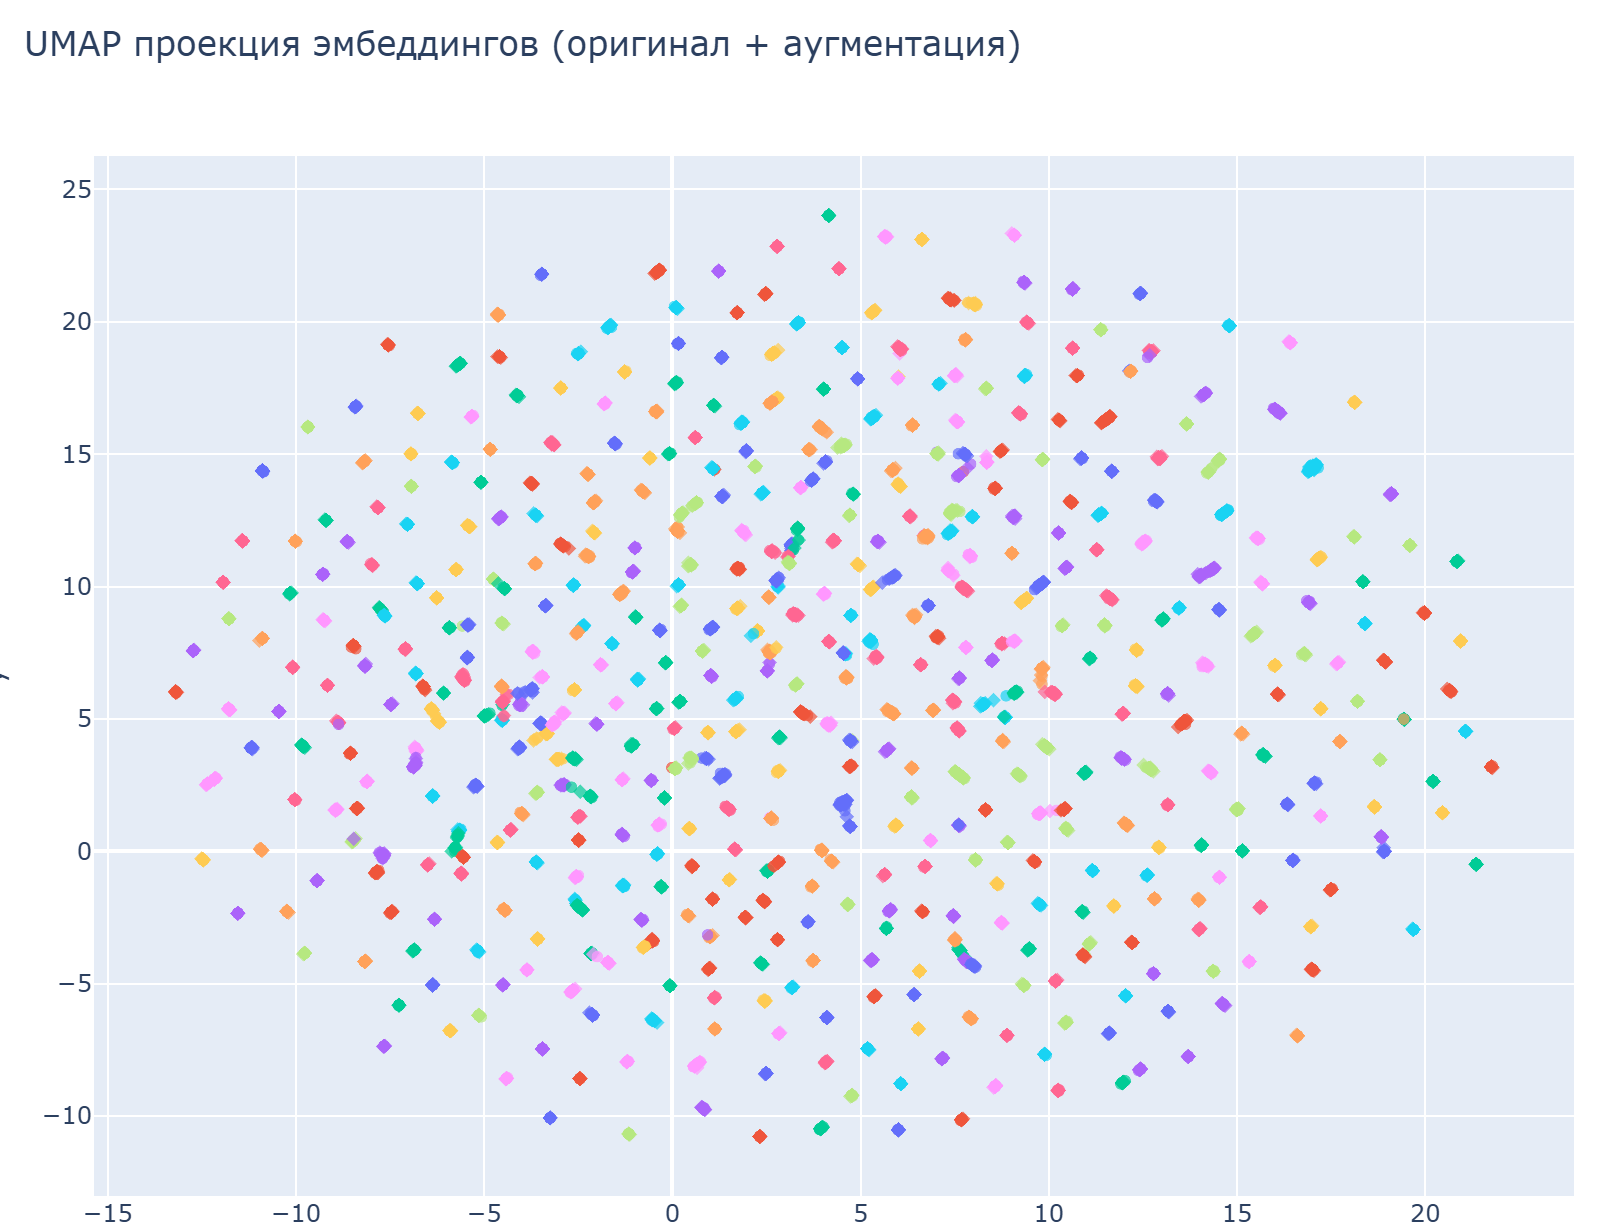

- пример приближения

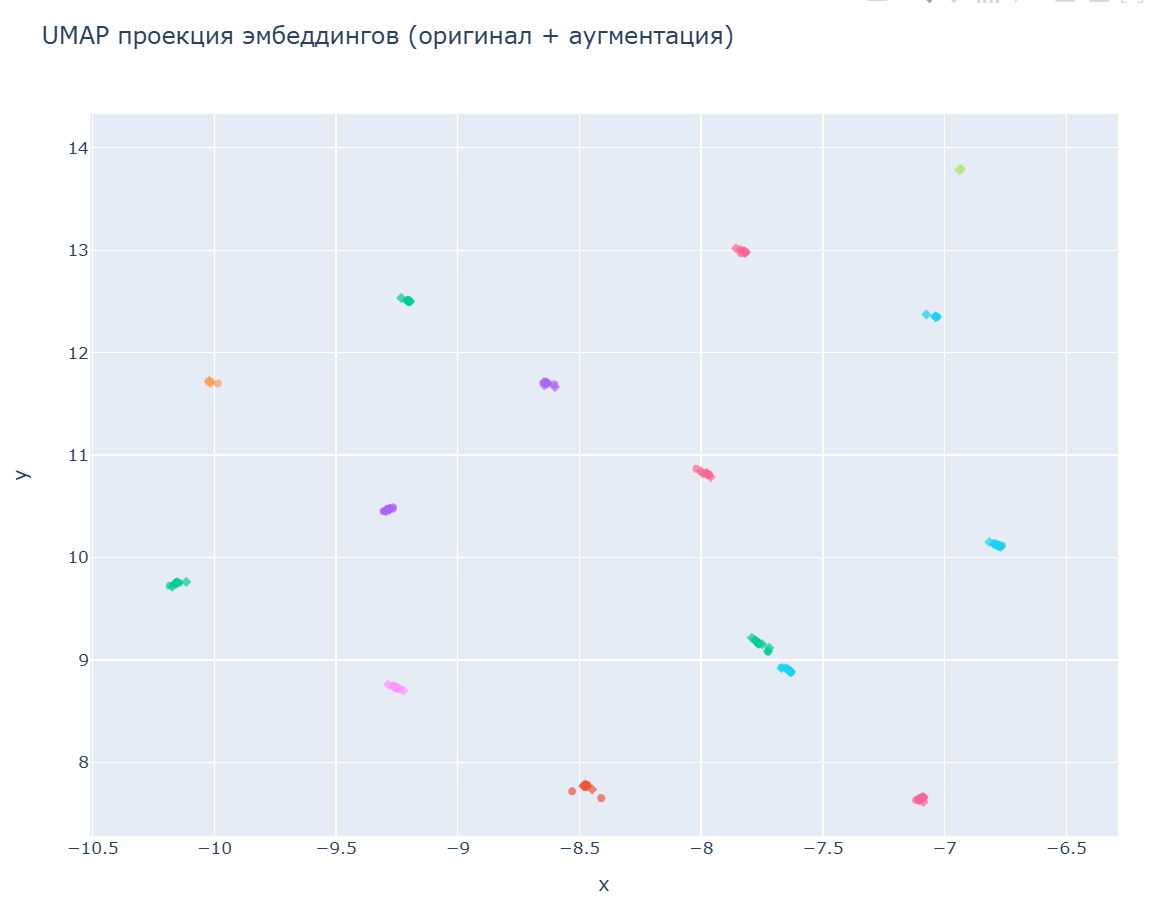

- кластер конкретного селебрити

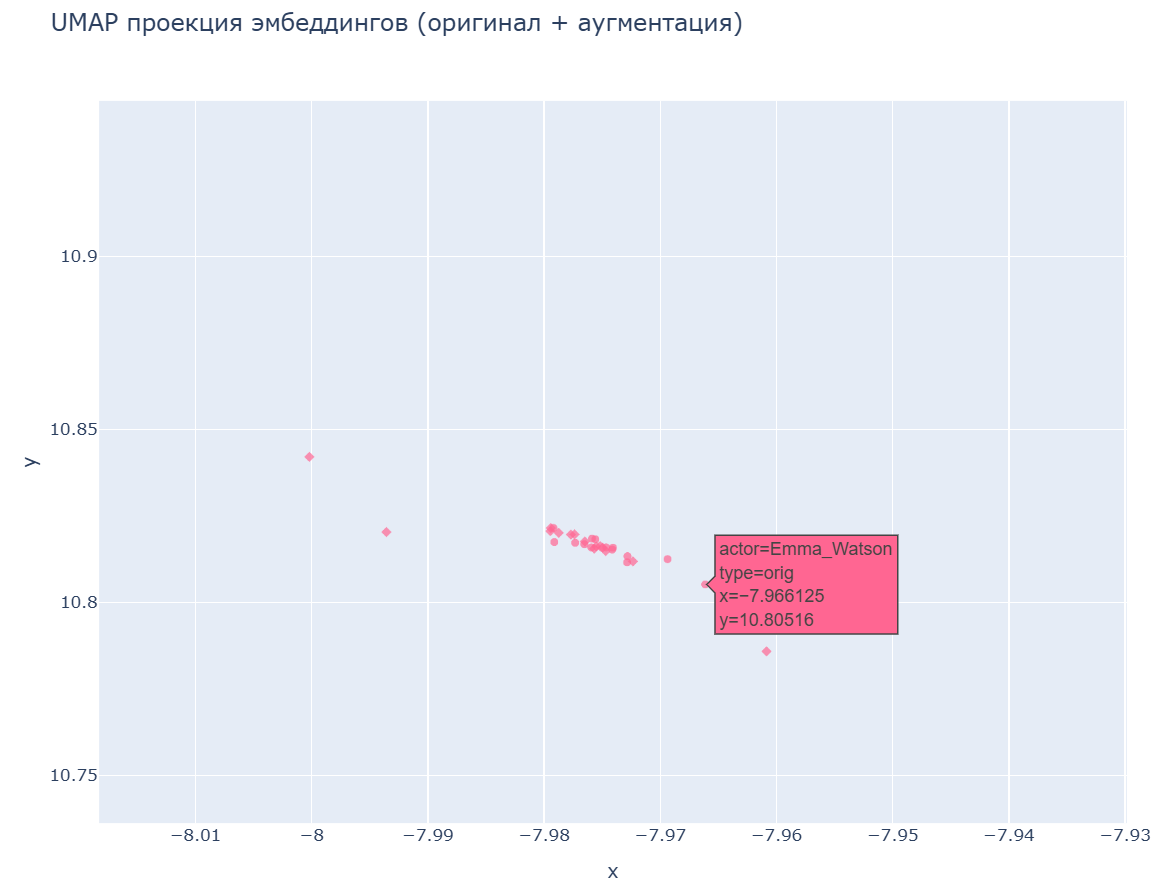

- Взято из scorring.ipynb


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


def neighbor_purity(X, y, k=5):
    """
    Возвращает среднюю долю "правильных соседей" — эмбеддингов той же личности.
    """
    nn = NearestNeighbors(n_neighbors=k+1, metric="cosine", n_jobs=-1).fit(X)
    _, idxs = nn.kneighbors(X)
    correct = 0
    for i in range(len(X)):
        neighbors = y[idxs[i][1:]]
        correct += np.sum(neighbors == y[i]) / k
    return correct / len(X)

purity_orig = neighbor_purity(X[y_type == "orig"], y[y_type == "orig"])
purity_aug  = neighbor_purity(X[y_type == "aug"],  y[y_type == "aug"])

print(f"Оригинальные эмбеддинги: {purity_orig:.3f}")
print(f" Аугментированные эмбеддинги: {purity_aug:.3f}")
purity_local = neighbor_purity(X, y, k=5)
purity_mean = purity_local.mean()
print(f"редняя доля правильных соседей (вкл. аугм.): {purity_mean:.3f}")

Оригинальные эмбеддинги: 0.989
 Аугментированные эмбеддинги: 0.989
редняя доля правильных соседей (вкл. аугм.): 0.996
